Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
   classification_report as cr,
   confusion_matrix,
   accuracy_score,
   precision_score,
   recall_score,
   f1_score,
   roc_curve,
   auc,
   make_scorer,
   cohen_kappa_score,
)
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
from tabulate import tabulate
from scipy.stats import zscore

Importing datasets

In [ ]:
d1 = pd.read_csv("/content/data0.csv",encoding='unicode_escape')
d2 = pd.read_csv("/content/d2.csv",encoding='unicode_escape')

In [ ]:
df = df = pd.concat([d1,d2],ignore_index = True,join="inner")

In [ ]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
199727,544812,22083,PAPER CHAIN KIT RETROSPOT,6,2/23/2011 15:58,5.79,NaN,United Kingdom
199728,544812,22084,PAPER CHAIN KIT EMPIRE,7,2/23/2011 15:58,5.79,NaN,United Kingdom
199729,544812,22087,PAPER BUNTING WHITE LACE,3,2/23/2011 15:58,5.79,NaN,United Kingdom
199730,544812,22088,PAPER BUNTING COLOURED LACE,1,2/23/2011 15:58,5.79,NaN,United Kingdom


In [ ]:
print(df.isnull().sum())

Invoice            0
StockCode          0
Description     1156
Quantity           0
InvoiceDate        0
Price              0
Customer ID    61922
Country            2
dtype: int64


In [ ]:
df.shape

(199732, 8)

In [ ]:
df = df.dropna()

In [ ]:
x = df.columns.values.tolist
print(x)

<built-in method tolist of numpy.ndarray object at 0x7b65eda198f0>


Feature Extraction

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
df['DaysSinceLastPurchase'] = (datetime.now() - df.groupby('Customer ID')['InvoiceDate'].transform('max')).dt.days - 4400
df['LastPurchaseDate'] = df.groupby('Customer ID')['InvoiceDate'].transform('max')
df['PurchasePeriod'] = (df.groupby('Customer ID')['InvoiceDate'].transform('max') - df.groupby('Customer ID')['InvoiceDate'].transform('min')).dt.days
df['Frequency'] = df['PurchasePeriod'] / df.groupby('Customer ID')['Invoice'].transform('nunique')
df['TotalCost'] = df['Quantity']*df['Price']


print(df)

       Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
199707  544811     22625                   RED KITCHEN SCALES         6   
199708  544811     22728            ALARM CLOCK BAKELIKE PINK        12   
199709  544811     22741                       FUNKY DIVA PEN        48   
199710  544811     22720    SET OF 3 CAKE TINS PANTRY DESIGN          6   
199711  544811      POST                              POSTAGE         3   

               InvoiceDate  Price  Customer ID         Country  \
0      2009-12-01 07:45:00   6.95

<ipython-input-11-3166967f244b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
<ipython-input-11-3166967f244b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DaysSinceLastPurchase'] = (datetime.now() - df.groupby('Customer ID')['InvoiceDate'].transform('max')).dt.days - 4400
<ipython-input-11-3166967f244b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Extracting total cost feature for each invoice per customer

In [ ]:
df2 = df.groupby(['Customer ID','Invoice','DaysSinceLastPurchase','Frequency'])['TotalCost'].sum().reset_index()
print(df2)

      Customer ID  Invoice  DaysSinceLastPurchase   Frequency  TotalCost
0         12346.0   491725                    338   33.333333      45.00
1         12346.0   491742                    338   33.333333      22.50
2         12346.0   491744                    338   33.333333      22.50
3         12346.0   492718                    338   33.333333      22.50
4         12346.0   492722                    338   33.333333       1.00
...           ...      ...                    ...         ...        ...
8147      18283.0   540350                    333  112.333333     108.45
8148      18283.0   541854                    333  112.333333     106.55
8149      18285.0   498149                    673    0.000000     427.00
8150      18286.0   492250                    736    0.000000     462.95
8151      18287.0  C489592                    751    0.000000      -5.10

[8152 rows x 5 columns]


In [ ]:
df1 = df.groupby(['Customer ID', 'Invoice','LastPurchaseDate','Frequency'])['TotalCost'].sum().reset_index()
print(df1)

      Customer ID  Invoice    LastPurchaseDate   Frequency  TotalCost
0         12346.0   491725 2011-01-18 10:17:00   33.333333      45.00
1         12346.0   491742 2011-01-18 10:17:00   33.333333      22.50
2         12346.0   491744 2011-01-18 10:17:00   33.333333      22.50
3         12346.0   492718 2011-01-18 10:17:00   33.333333      22.50
4         12346.0   492722 2011-01-18 10:17:00   33.333333       1.00
...           ...      ...                 ...         ...        ...
8147      18283.0   540350 2011-01-23 14:58:00  112.333333     108.45
8148      18283.0   541854 2011-01-23 14:58:00  112.333333     106.55
8149      18285.0   498149 2010-02-17 10:24:00    0.000000     427.00
8150      18286.0   492250 2009-12-16 10:45:00    0.000000     462.95
8151      18287.0  C489592 2009-12-01 14:19:00    0.000000      -5.10

[8152 rows x 5 columns]


Extracting return, total return and assigning pay method features

In [ ]:
y = []
return_list = []
for i in range(len(df1['Invoice'])):
    y += [random.randint(0, 1)]
for i in df1['Invoice']:
    try:
        x = int(i)
        return_list += [0,]
    except:
        return_list +=[1,]
df1['pay_mtd'] = y
df1['return'] = return_list

return_count = df1.groupby('Customer ID')['return'].sum().reset_index()
return_count.rename(columns={'return': 'Return_Count'}, inplace=True)

# Merge the return count with the original DataFrame
df1 = df1.merge(return_count, on='Customer ID', how='left')

print(df1)

      Customer ID  Invoice    LastPurchaseDate   Frequency  TotalCost  \
0         12346.0   491725 2011-01-18 10:17:00   33.333333      45.00   
1         12346.0   491742 2011-01-18 10:17:00   33.333333      22.50   
2         12346.0   491744 2011-01-18 10:17:00   33.333333      22.50   
3         12346.0   492718 2011-01-18 10:17:00   33.333333      22.50   
4         12346.0   492722 2011-01-18 10:17:00   33.333333       1.00   
...           ...      ...                 ...         ...        ...   
8147      18283.0   540350 2011-01-23 14:58:00  112.333333     108.45   
8148      18283.0   541854 2011-01-23 14:58:00  112.333333     106.55   
8149      18285.0   498149 2010-02-17 10:24:00    0.000000     427.00   
8150      18286.0   492250 2009-12-16 10:45:00    0.000000     462.95   
8151      18287.0  C489592 2009-12-01 14:19:00    0.000000      -5.10   

      pay_mtd  return  Return_Count  
0           1       0             2  
1           1       0             2  
2        

Extracting pay method as normalized value for each customer

In [ ]:
df1['paymtd'] = df1.groupby('Customer ID')['pay_mtd'].transform(lambda x: x.sum() / len(x))

Adding pay method to dataset

In [ ]:
df3 = pd.merge(df2, df1[['Invoice', 'paymtd', 'return', 'Return_Count']], on='Invoice', how='left')
df3.rename(columns={'DaysSinceLastPurchase': 'Recency'}, inplace=True)
df3

,Customer ID,Invoice,Recency,Frequency,TotalCost,paymtd,return,Return_Count
0,12346.0,491725,338,33.333333,45.00,0.583333,0,2
1,12346.0,491742,338,33.333333,22.50,0.583333,0,2
2,12346.0,491744,338,33.333333,22.50,0.583333,0,2
3,12346.0,492718,338,33.333333,22.50,0.583333,0,2
4,12346.0,492722,338,33.333333,1.00,0.583333,0,2
...,...,...,...,...,...,...,...,...
8147,18283.0,540350,333,112.333333,108.45,0.333333,0,0
8148,18283.0,541854,333,112.333333,106.55,0.333333,0,0
8149,18285.0,498149,673,0.000000,427.00,1.000000,0,0
8150,18286.0,492250,736,0.000000,462.95,1.000000,0,0


In [ ]:
df3 = df3.groupby(['Customer ID','Recency','Frequency','paymtd','Return_Count'])['TotalCost'].sum().reset_index()
df3

,Customer ID,Recency,Frequency,paymtd,Return_Count,TotalCost
0,12346.0,338,33.333333,0.583333,2,100.00
1,12347.0,330,24.500000,1.000000,0,1187.18
2,12348.0,331,19.500000,0.500000,0,1120.24
3,12349.0,748,0.000000,1.000000,1,-24.15
4,12350.0,323,0.000000,0.000000,0,334.40
...,...,...,...,...,...,...
2618,18277.0,331,0.000000,1.000000,1,-12.75
2619,18283.0,333,112.333333,0.333333,0,316.35
2620,18285.0,673,0.000000,1.000000,0,427.00
2621,18286.0,736,0.000000,1.000000,0,462.95


Assigining classes to customers based on credit score

In [ ]:
df3['Recency'] = 1-(df3['Recency']/1000)
df3['c_s'] = df3['Recency']+(df3['TotalCost']/1000) +(df3['Frequency']/100)+ df3['paymtd'] - (df3['Return_Count']/10)

df3['c_s'] = pd.to_numeric(df3['c_s'], errors='coerce')
df3['Class'] = pd.qcut(df3['c_s'], q=[0, 0.25, 0.65, 0.85, 1.0], labels=['0', '1', '2', '3'])
df3 = df3.drop(columns=['c_s'])

Dataset with outliers

In [ ]:
df3

,Customer ID,Recency,Frequency,paymtd,Return_Count,TotalCost,Class
0,12346.0,0.662,33.333333,0.583333,2,100.00,1
1,12347.0,0.670,24.500000,1.000000,0,1187.18,2
2,12348.0,0.669,19.500000,0.500000,0,1120.24,2
3,12349.0,0.252,0.000000,1.000000,1,-24.15,1
4,12350.0,0.677,0.000000,0.000000,0,334.40,0
...,...,...,...,...,...,...,...
2618,18277.0,0.669,0.000000,1.000000,1,-12.75,1
2619,18283.0,0.667,112.333333,0.333333,0,316.35,2
2620,18285.0,0.327,0.000000,1.000000,0,427.00,1
2621,18286.0,0.264,0.000000,1.000000,0,462.95,1


KNN Classifier with outliers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define features and target variable
features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
target = 'Class'

X = df3[features]
y = df3[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors as needed

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn_model.predict(X_test)

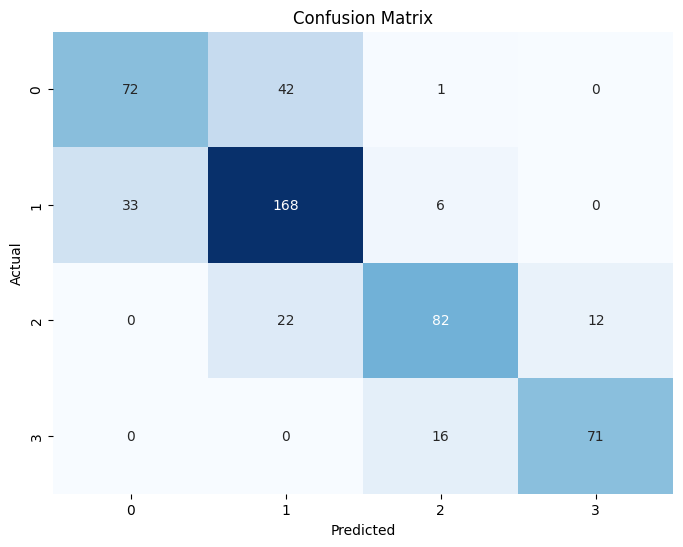

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       0.69      0.63      0.65       115
           1       0.72      0.81      0.77       207
           2       0.78      0.71      0.74       116
           3       0.86      0.82      0.84        87

    accuracy                           0.75       525
   macro avg       0.76      0.74      0.75       525
weighted avg       0.75      0.75      0.75       525

+-----------+----------+
|  Metric   |  Score   |
+===========+==========+
| Accuracy  | 0.748571 |
+-----------+----------+
| Precision | 0.75003  |
+-----------+----------+
|  Recall   | 0.748571 |
+-----------+----------+
| F1 Score  | 0.747538 |
+-----------+----------+
|   Kappa   | 0.646654 |
+-----------+----------+


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder



# # Define features and target variable
# features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
# target = 'Class'

# X = df3[features]
# y = df3[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the Gaussian Naive Bayes model
# nb_model = GaussianNB()

# # Train the model
# nb_model.fit(X_train, y_train)

# # Make predictions on the testing set
# y_pred = nb_model.predict(X_test)

# # Evaluate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Accuracy of the Naive Bayes model: {accuracy:.2f}')



In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder



# # Define features and target variable
# features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
# target = 'Class'

# X = df3[features]
# y = df3[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the Logistic Regression model
# logreg_model = LogisticRegression()

# # Train the model
# logreg_model.fit(X_train, y_train)

# # Make predictions on the testing set
# y_pred = logreg_model.predict(X_test)

# # Evaluate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Accuracy of the Logistic Regression model: {accuracy:.2f}')


Decision Tree Classifier with outliers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
# Define features and target variable
features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
target = 'Class'

X = df3[features]
y = df3[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dt_model.predict(X_test)

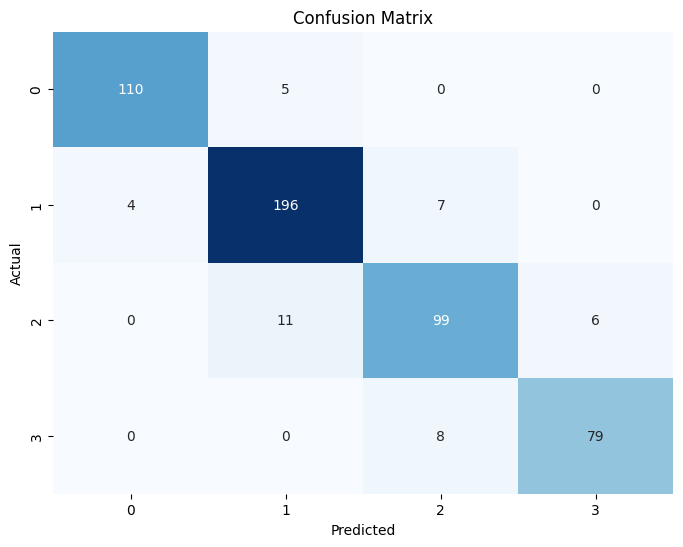

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       115
           1       0.92      0.95      0.94       207
           2       0.87      0.85      0.86       116
           3       0.93      0.91      0.92        87

    accuracy                           0.92       525
   macro avg       0.92      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525

+-----------+----------+
|  Metric   |  Score   |
+===========+==========+
| Accuracy  | 0.921905 |
+-----------+----------+
| Precision | 0.921787 |
+-----------+----------+
|  Recall   | 0.921905 |
+-----------+----------+
| F1 Score  | 0.921754 |
+-----------+----------+
|   Kappa   | 0.891294 |
+-----------+----------+


In [ ]:
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder



# # Define features and target variable
# features = ['Recency', 'Frequency', 'TotalCost', 'paymtd','Return_Count']
# target = 'Class'

# X = df3[features]
# y = df3[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the XGBoost model
# xgb_model = XGBClassifier(random_state=42)

# # Train the model
# xgb_model.fit(X_train, y_train)

# # Make predictions on the testing set
# y_pred = xgb_model.predict(X_test)

# # Evaluate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Accuracy of the Gradient Boosting (XGBoost) model: {accuracy:.2f}')


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.preprocessing import LabelEncoder



# # Define features and target variable
# features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
# target = 'Class'

# X = df3[features]
# y = df3[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Initialize the neural network model
# model = Sequential()

# # Add input layer and one hidden layer
# model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# # Add output layer
# model.add(Dense(units=1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# # Make predictions on the testing set
# y_pred_proba = model.predict(X_test_scaled)
# y_pred = [1 if proba >= 0.5 else 0 for proba in y_pred_proba]

# # Evaluate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Accuracy of the Neural Network model: {accuracy:.2f}')


SVM with outliers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# Define features and target variable
features = ['Recency', 'Frequency', 'TotalCost', 'paymtd','Return_Count']
target = 'Class'

X = df3[features]
y = df3[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM model
svm_model = SVC(kernel='rbf', random_state=42)  # 'rbf' stands for Radial basis function (Gaussian)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = svm_model.predict(X_test_scaled)

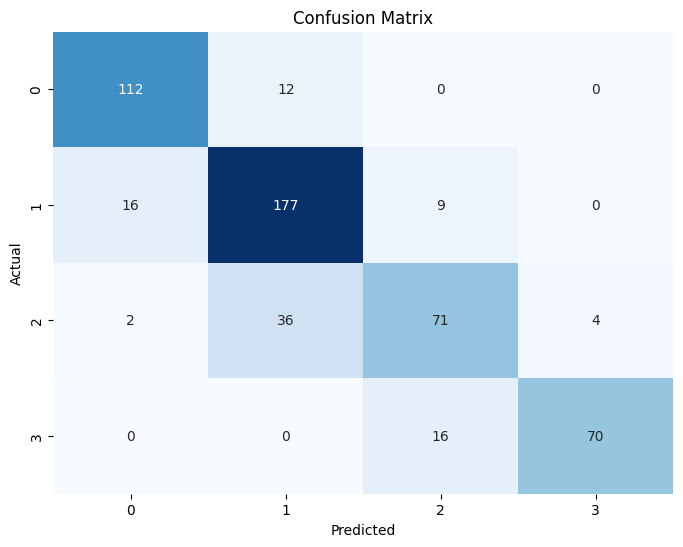

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       124
           1       0.79      0.88      0.83       202
           2       0.74      0.63      0.68       113
           3       0.95      0.81      0.88        86

    accuracy                           0.82       525
   macro avg       0.83      0.81      0.82       525
weighted avg       0.82      0.82      0.82       525

+-----------+----------+
|  Metric   |  Score   |
+===========+==========+
| Accuracy  | 0.819048 |
+-----------+----------+
| Precision | 0.820308 |
+-----------+----------+
|  Recall   | 0.819048 |
+-----------+----------+
| F1 Score  | 0.816849 |
+-----------+----------+
|   Kappa   | 0.746625 |
+-----------+----------+


Random Forest with outliers

In [ ]:
# Define features and target variable
features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
target = 'Class'

X = df3[features]
y = df3[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)


y_pred = random_forest_model.predict(X_test)

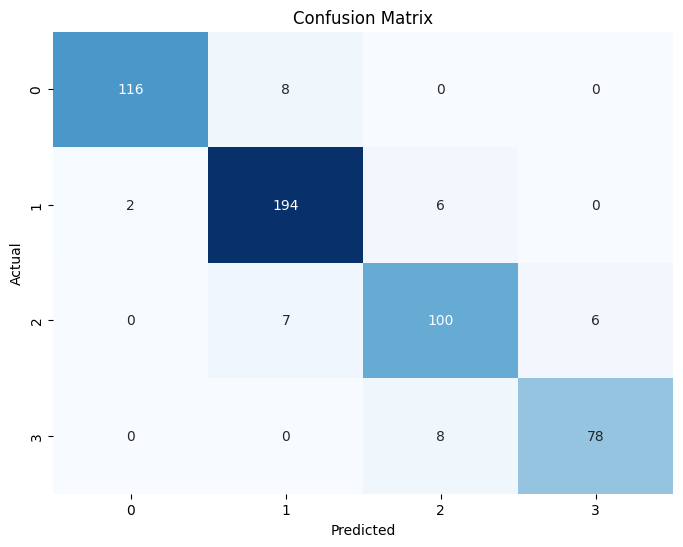

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=random_forest_model.classes_, yticklabels=random_forest_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       124
           1       0.93      0.96      0.94       202
           2       0.88      0.88      0.88       113
           3       0.93      0.91      0.92        86

    accuracy                           0.93       525
   macro avg       0.93      0.92      0.93       525
weighted avg       0.93      0.93      0.93       525

+-----------+----------+
|  Metric   |  Score   |
+===========+==========+
| Accuracy  | 0.929524 |
+-----------+----------+
| Precision | 0.930249 |
+-----------+----------+
|  Recall   | 0.929524 |
+-----------+----------+
| F1 Score  | 0.929617 |
+-----------+----------+
|   Kappa   | 0.902224 |
+-----------+----------+


Remove Outliers using z-score and IQR

In [ ]:

columns_to_check = ['Recency', 'Frequency', 'paymtd', 'Return_Count', 'TotalCost']

# Z-Score Method
z_scores = zscore(df3[columns_to_check])
abs_z_scores = abs(z_scores)
outliers_z = (abs_z_scores > 3).all(axis=1)  # Adjust the threshold as needed

# IQR Method
Q1 = df3[columns_to_check].quantile(0.25)
Q3 = df3[columns_to_check].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df3[columns_to_check] < (Q1 - 1.5 * IQR)) | (df3[columns_to_check] > (Q3 + 1.5 * IQR))).any(axis=1)

# Combine both methods to identify outliers
outliers = outliers_z | outliers_iqr

# Remove outliers from the DataFrame
df4= df3[~outliers]

# Display the DataFrame without outliers
# print(df4)
# -------------------------------------------------------
# import pandas as pd
# from scipy.stats import zscore

# columns_to_check = ['Recency', 'Frequency', 'paymtd', 'Return_Count', 'TotalCost']

# # Z-Score Method
# z_scores = zscore(df3[columns_to_check])
# abs_z_scores = abs(z_scores)
# outliers_z = (abs_z_scores > 3).any(axis=1)  # Adjust the threshold as needed

# # Replace outliers with the mean value
# df4 = df3.copy()
# for column in columns_to_check:
#     column_mean = df4[column].mean()
#     df4.loc[outliers_z, column] = column_mean

# # Display the DataFrame with transformed outliers
# print(df4)
# ---------------------------------------------------------import pandas as pd
# import numpy as np
# from scipy.stats import zscore

# columns_to_check = ['Recency', 'Frequency', 'paymtd', 'Return_Count', 'TotalCost']

# # Z-Score Method
# z_scores = zscore(df3[columns_to_check])
# abs_z_scores = abs(z_scores)
# outliers_z = (abs_z_scores > 3).any(axis=1)  # Adjust the threshold as needed

# # Log transform outliers
# df4 = df3.copy()
# for column in columns_to_check:
#     # Log transform only the outliers
#     df4.loc[outliers_z, column] = np.log1p(df4.loc[outliers_z, column])

# # Display the DataFrame with log-transformed outliers
# print(df4)


Dataframe Without Outliers

In [ ]:
df4

,Customer ID,Recency,Frequency,paymtd,Return_Count,TotalCost,Class
0,12346.0,0.663,33.333333,0.500000,2,100.00,1
1,12347.0,0.671,24.500000,0.000000,0,1187.18,1
2,12348.0,0.670,19.500000,0.500000,0,1120.24,2
3,12349.0,0.253,0.000000,0.000000,1,-24.15,0
4,12350.0,0.678,0.000000,0.000000,0,334.40,0
...,...,...,...,...,...,...,...
2618,18277.0,0.670,0.000000,0.000000,1,-12.75,0
2619,18283.0,0.668,112.333333,0.666667,0,316.35,2
2620,18285.0,0.328,0.000000,1.000000,0,427.00,1
2621,18286.0,0.265,0.000000,1.000000,0,462.95,1


KNN Classifier without outliers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define features and target variable
features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
target = 'Class'

X = df4[features]
y = df4[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors as needed

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn_model.predict(X_test)

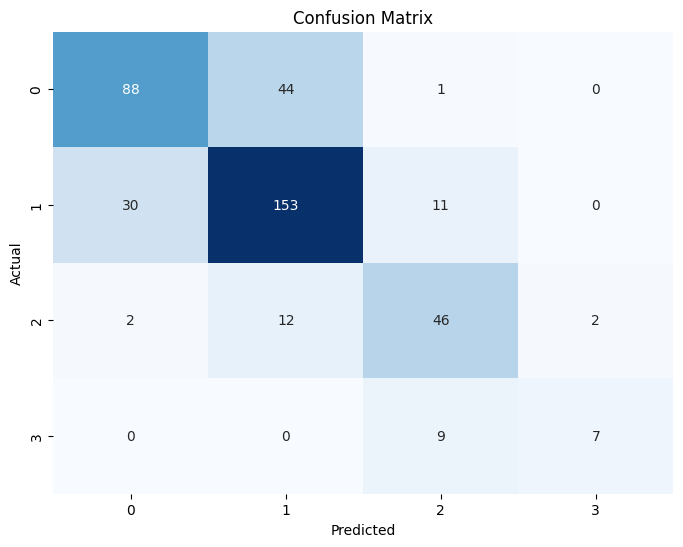

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=random_forest_model.classes_, yticklabels=random_forest_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       0.73      0.66      0.70       133
           1       0.73      0.79      0.76       194
           2       0.69      0.74      0.71        62
           3       0.78      0.44      0.56        16

    accuracy                           0.73       405
   macro avg       0.73      0.66      0.68       405
weighted avg       0.73      0.73      0.72       405

+-----------+----------+
|  Metric   |  Score   |
+===========+==========+
| Accuracy  | 0.725926 |
+-----------+----------+
| Precision | 0.727319 |
+-----------+----------+
|  Recall   | 0.725926 |
+-----------+----------+
| F1 Score  | 0.723467 |
+-----------+----------+
|   Kappa   | 0.564478 |
+-----------+----------+


Decision Tree Classifier without outliers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
# Define features and target variable
features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
target = 'Class'

X = df4[features]
y = df4[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dt_model.predict(X_test)

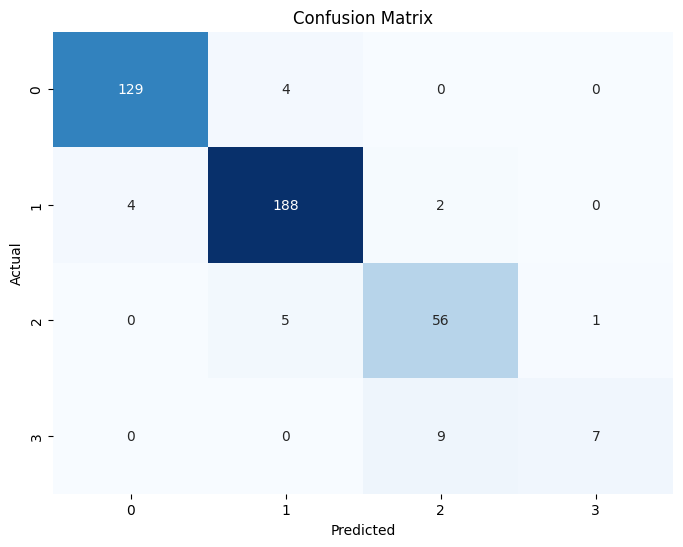

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=random_forest_model.classes_, yticklabels=random_forest_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       133
           1       0.95      0.97      0.96       194
           2       0.84      0.90      0.87        62
           3       0.88      0.44      0.58        16

    accuracy                           0.94       405
   macro avg       0.91      0.82      0.85       405
weighted avg       0.94      0.94      0.94       405

+-----------+----------+
|  Metric   |  Score   |
+===========+==========+
| Accuracy  | 0.938272 |
+-----------+----------+
| Precision | 0.938168 |
+-----------+----------+
|  Recall   | 0.938272 |
+-----------+----------+
| F1 Score  | 0.935112 |
+-----------+----------+
|   Kappa   | 0.90249  |
+-----------+----------+


Random Forest without outliers

In [ ]:
# Define features and target variable
features = ['Recency', 'Frequency', 'TotalCost', 'paymtd', 'Return_Count']
target = 'Class'

X = df4[features]
y = df4[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)


y_pred = random_forest_model.predict(X_test)

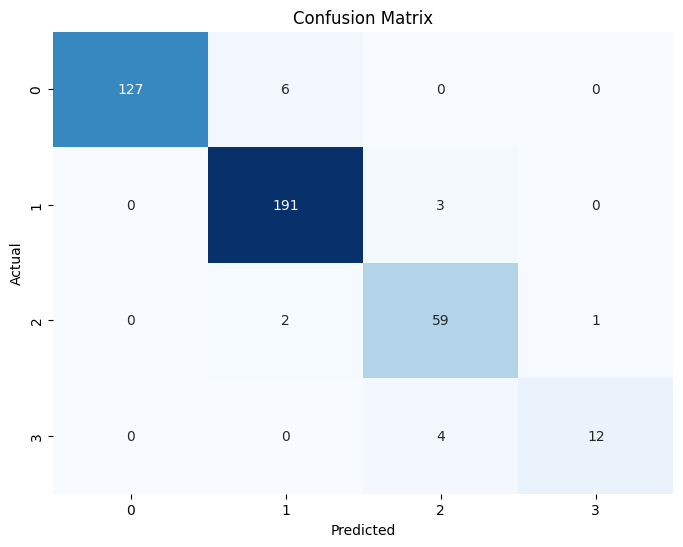

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=random_forest_model.classes_, yticklabels=random_forest_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test,y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       133
           1       0.96      0.98      0.97       194
           2       0.89      0.95      0.92        62
           3       0.92      0.75      0.83        16

    accuracy                           0.96       405
   macro avg       0.94      0.91      0.92       405
weighted avg       0.96      0.96      0.96       405

+-----------+----------+
|  Metric   |  Score   |
+===========+==========+
| Accuracy  | 0.960494 |
+-----------+----------+
| Precision | 0.961468 |
+-----------+----------+
|  Recall   | 0.960494 |
+-----------+----------+
| F1 Score  | 0.960243 |
+-----------+----------+
|   Kappa   | 0.937829 |
+-----------+----------+


SVM without outliers

In [ ]:

features = ['Recency', 'Frequency', 'paymtd', 'Return_Count', 'TotalCost']
target = 'Class'

# Split the data into features and target variable
X = df3[features]
y = df3[target]

# Perform polynomial feature transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Initialize the SVM classifier with a polynomial kernel
svm_model = SVC(kernel='poly', degree=2, C=1.0, gamma='scale', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)


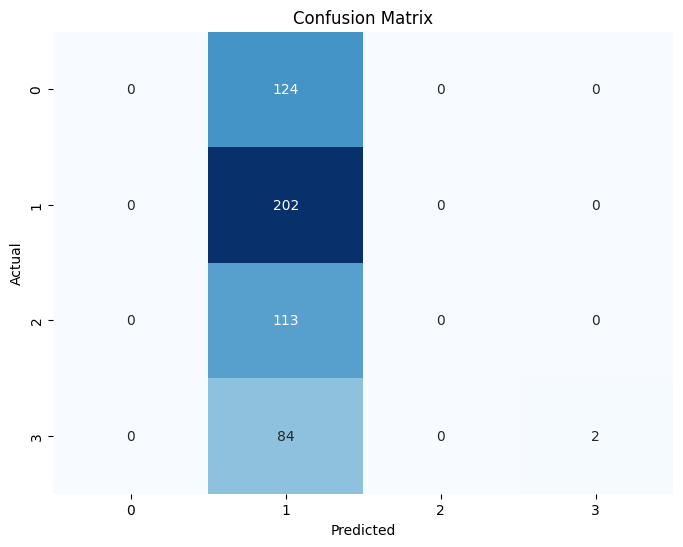

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=random_forest_model.classes_, yticklabels=random_forest_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test,y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       124
           1       0.39      1.00      0.56       202
           2       0.00      0.00      0.00       113
           3       1.00      0.02      0.05        86

    accuracy                           0.39       525
   macro avg       0.35      0.26      0.15       525
weighted avg       0.31      0.39      0.22       525

+-----------+------------+
|  Metric   |   Score    |
+===========+============+
| Accuracy  |  0.388571  |
+-----------+------------+
| Precision |  0.312417  |
+-----------+------------+
|  Recall   |  0.388571  |
+-----------+------------+
| F1 Score  |  0.221851  |
+-----------+------------+
|   Kappa   | 0.00754975 |
+-----------+------------+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Random Forest With Polynomial Features

In [ ]:
# Select features and target variable
columns_to_use = ['Recency', 'Frequency', 'paymtd', 'Return_Count', 'TotalCost']
X = df4[columns_to_use]
y = df4['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_poly, y_train)

# Make predictions
y_pred = model.predict(X_test_poly)


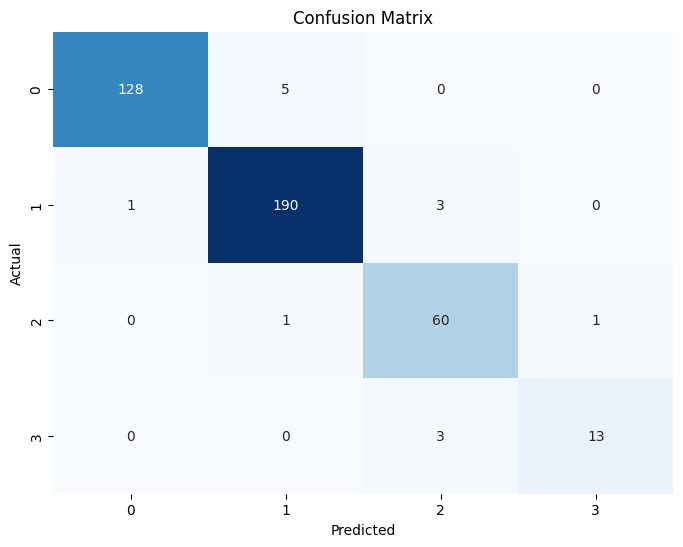

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=random_forest_model.classes_, yticklabels=random_forest_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(cr(y_test,y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa'],
    'Score': [accuracy, precision, recall, f1, kappa]
})
table = tabulate(metrics_df, headers='keys', tablefmt='grid', colalign=('center', 'center'), numalign='center', showindex=False)

# Print the table
print(table)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       133
           1       0.97      0.98      0.97       194
           2       0.91      0.97      0.94        62
           3       0.93      0.81      0.87        16

    accuracy                           0.97       405
   macro avg       0.95      0.93      0.94       405
weighted avg       0.97      0.97      0.97       405

+-----------+----------+
|  Metric   |  Score   |
+===========+==========+
| Accuracy  | 0.965432 |
+-----------+----------+
| Precision | 0.966052 |
+-----------+----------+
|  Recall   | 0.965432 |
+-----------+----------+
| F1 Score  | 0.965362 |
+-----------+----------+
|   Kappa   | 0.945756 |
+-----------+----------+


In [ ]:
# cod_list = []
# emi_list = []
# delivery_benefits_list = []

# for x in y_pred:
#   if int(x) == 0:
#     cod_list += ['n',]
#     emi_list += ['n',]
#     delivery_benefits_list += ['n',]
#   elif int(x) == 1:
#     cod_list += ['n',]
#     emi_list += ['n',]
#     delivery_benefits_list += ['y',]
#   elif int(x) == 2:
#     cod_list += ['y',]
#     emi_list += ['n',]
#     delivery_benefits_list += ['y',]
#   elif int(x) == 3:
#     cod_list += ['y',]
#     emi_list += ['y',]
#     delivery_benefits_list += ['y',]

# final_classes = {'class':y_pred,'delivery_benefits' : delivery_benefits_list,'cash_on_delivery' : cod_list, 'emi' : emi_list}

# df = pd.DataFrame(final_classes)
# # print(len(delivery_benefits_list))